In [2]:
import openmc
import numpy as np
from matplotlib import pyplot as plt

 - demonstrate tallies, filters, and scores
 - compute fission power and discuss heating tallies
 - talk about and demonstrate statepoint file handles
 - demonstrate mesh tally

The tally capability in OpenMC takes a similar philosophy as that employed in the MC21 Monte Carlo code to give maximum flexibility in specifying tallies while still maintaining scalability. Any tally in OpenMC can be described with the following form:

$$ 
 X = \underbrace{\int d\mathbf{r} \int d\mathbf{\Omega} \int
    dE}_{\text{filters}} \underbrace{f(\mathbf{r}, \mathbf{\Omega},
    E)}_{\text{scores}} \psi (\mathbf{r}, \mathbf{\Omega}, E)
$$

where filters set the limits of the integrals and the scoring function is convolved with particle information (e.g. reaction type, current material, etc.).

Total number of bins in a tally:

$$ N_{bins} =  \underbrace{\prod_{f}^{F} N_{f}}_{filters} \times N_{scores} \times N_{nuclides} $$

In [3]:
model = openmc.examples.pwr_pin_cell()

In [4]:
model.settings.particles = 10_000
model.settings.batches = 50
model.settings.inactive = 10

tally = openmc.Tally()

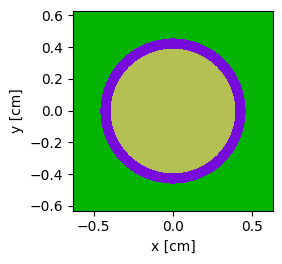

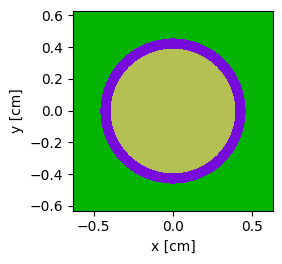

In [7]:
model.geometry.plot()
plt.show()

In [5]:
model.materials

[Material
 	ID             =	1
 	Name           =	UO2 (2.4%)
 	Temperature    =	None
 	Density        =	10.29769 [g/cm3]
 	Volume         =	None [cm^3]
 	Depletable     =	True
 	S(a,b) Tables  
 	Nuclides       
 	U234           =	4.4843e-06   [ao]
 	U235           =	0.00055815   [ao]
 	U238           =	0.022408     [ao]
 	O16            =	0.045829     [ao],
 Material
 	ID             =	2
 	Name           =	Zircaloy
 	Temperature    =	None
 	Density        =	6.55 [g/cm3]
 	Volume         =	None [cm^3]
 	Depletable     =	False
 	S(a,b) Tables  
 	Nuclides       
 	Zr90           =	0.021827     [ao]
 	Zr91           =	0.00476      [ao]
 	Zr92           =	0.0072758    [ao]
 	Zr94           =	0.0073734    [ao]
 	Zr96           =	0.0011879    [ao],
 Material
 	ID             =	3
 	Name           =	Hot borated water
 	Temperature    =	None
 	Density        =	0.740582 [g/cm3]
 	Volume         =	None [cm^3]
 	Depletable     =	False
 	S(a,b) Tables  
 	S(a,b)         =	('c_H_in_H2O', 1.0)
 	Nuc

In [8]:
tally.scores = ['heating', 'heating-local', 'kappa-fission', 'fission']

$$ \frac{\frac{eV}{src-p}}{\frac{fissions}{src-p}}  = \frac{eV}{fission} $$

In [9]:
model.settings.photon_transport = True
xs_loc = '/filespace/s/shriwise/data/xs/openmc/endfb-vii.1-hdf5/cross_sections.xml'
openmc.config['cross_sections'] = xs_loc

In [10]:
model.tallies = [tally]

In [11]:
sp_file = model.run(threads=4)
print(sp_file)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [12]:
statepoint = openmc.StatePoint(sp_file)


In [35]:
import os
os.listdir('.')

['tallies.ipynb',
 'statepoint.50.h5',
 'tallies.out',
 'model.xml',
 'summary.h5',
 '.ipynb_checkpoints']

In [13]:
statepoint.keff

1.1624152121727236+/-0.0013189930737785675

In [14]:
statepoint.k_generation

array([1.15866163, 1.14795435, 1.14863399, 1.13723271, 1.14844257,
       1.16873609, 1.16263338, 1.14253623, 1.17099238, 1.16733718,
       1.15104269, 1.17244933, 1.15355631, 1.15040904, 1.17679932,
       1.16163095, 1.16894017, 1.16619776, 1.17078715, 1.16254852,
       1.15036153, 1.18347499, 1.15423458, 1.17003687, 1.15967215,
       1.15881018, 1.16109544, 1.1575117 , 1.16593641, 1.18115784,
       1.15295851, 1.18133558, 1.16270452, 1.17085028, 1.17875278,
       1.18399753, 1.14973585, 1.11900909, 1.15380324, 1.1515369 ,
       1.16506695, 1.15119865, 1.14005003, 1.16800571, 1.16251021,
       1.16881145, 1.15364155, 1.16023601, 1.17567083, 1.16380223])

In [15]:
statepoint.tallies

{1: Tally
 	ID             =	1
 	Name           =	
 	Filters        =	
 	Nuclides       =	total
 	Scores         =	['heating', 'heating-local', 'kappa-fission', 'fission']
 	Estimator      =	collision
 	Multiply dens. =	True}

In [16]:
tally_result = statepoint.tallies[tally.id]

In [17]:
tally.mean

In [21]:
tally_result.mean.shape

(1, 1, 4)

In [19]:
tally_result.std_dev

array([[[1.02864353e+05, 1.06159710e+05, 1.08243730e+05, 5.59952867e-04]]])

In [28]:
heating, heating_local, kappa_fission, fission_rate = \
tally_result.get_values(scores=['heating', 'heating-local', 'kappa-fission', 'fission']).flatten()

In [29]:
print(heating, heating_local, kappa_fission, fission_rate)

94109392.04180504 94185864.7155524 91497450.13340844 0.47243080167810375


In [32]:
print(f'Fission heating: {1e-6 * kappa_fission / fission_rate} MeV')

Fission heating: 193.6737609156807 MeV


In [33]:
tally_result.num_realizations

40

In [36]:
statepoint.close()

In [37]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/filespace/s/shriwise/ne506/content/openmc/in-class/statepoint.50.h5')

In [42]:
# statepoint = openmc.StatePoint(sp_file)
with openmc.StatePoint(sp_file) as statepoint:
    # extract tallies here
    tally_result = statepoint.tallies[tally.id]

# continue work
tally_mean = tally_result.mean
print(tally_mean)

[[[9.41093920e+07 9.41858647e+07 9.14974501e+07 4.72430802e-01]]]
